## Wellhead Pressure Prediction
Anadarko Petroleum Corporation

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras, set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline
np.random.seed(42)
set_random_seed(42)

In [11]:
class WellheadPressurePrediction:
    def __init__(self, df, sample_size):
        self.df = df
        self.sample_size = sample_size
        self.predictions = np.empty(0)
        self.actuals = np.empty(0)
        self.test_rmse = []
        self.train_rmse = []
        self.setup()
        self.preprocess()
        self.normalize()
        self.reshape()

    def setup(self):
        self.model = Sequential()
        self.model.add(Conv1D(10,3,input_shape=(self.sample_size,4), activation = 'relu'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Conv1D(10,3, activation = 'relu'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Conv1D(10,3, activation = 'relu'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(SimpleRNN(10, return_sequences = True, dropout=0.2))
        self.model.add(SimpleRNN(10))
        self.model.add(Dense(1))
        self.model.compile(loss='mse', optimizer='adam')
        
    def train(self, x, y):
        early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=1, mode='min')
        self.model.fit(x, y, epochs=100, batch_size=200, verbose=0, callbacks=[early_stop])

    def predict(self, x):
        predictions = self.model.predict(x)
        return predictions
    
    def calculate_rmse(self, x, y, predictions):
        x = x.reshape((x.shape[0], -1))
        y = y.reshape((len(y), 1))
        predictions_inverted = np.concatenate((x, predictions), axis=1)
        predictions_inverted = self.scaler.inverse_transform(predictions_inverted)
        predictions_inverted = predictions_inverted[:,-1]
        invert_y = np.concatenate((x, y), axis=1)
        invert_y = self.scaler.inverse_transform(invert_y)
        invert_y = invert_y[:,-1]
        rmse = np.sqrt(mean_squared_error(invert_y, predictions_inverted))
        return rmse, predictions_inverted, invert_y
    
    def normalize(self):
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaler = self.scaler.fit(self.dataset)
        self.normalized = self.scaler.transform(self.dataset)

    def reshape(self):
        self.x_data = self.normalized[:, 0:self.N_feature]
        self.y_data = self.normalized[:, self.N_feature]
        self.data = np.reshape(self.x_data, (self.x_data.shape[0], -1, 4))
    
    def preprocess(self):
        self.df['date_time']=pd.to_datetime(self.df.date_time.iloc[:])
        t = (self.df.date_time-self.df.date_time.iloc[0]).dt.total_seconds()
        self.df.loc[:,'new_time'] = t

        df1 = self.df[(self.df.prop_conc_1 > 0)]
        Nrow = df1.shape[0]
        Nrow1 = Nrow - sample_size
        data1 = df1[['prop_conc_1','bh_prop_conc','fr_conc_2','slurry_rate']]
        data2 = df1['wellhead_pressure_1']
        X = np.zeros((Nrow1, sample_size,4))
        Y = np.zeros(Nrow1)
        time_n = np.zeros((Nrow1,1))
        for i in range(0, Nrow1):
            X[i,:,:] = data1.iloc[i:(i+sample_size),:]
            Y[i] = data2.iloc[(i+sample_size-1)]
            time_n[i] = df1.new_time.iloc[i+sample_size]
        df2 = pd.DataFrame()
        for i in range(0, sample_size):
            col_name1 = "prop_conc(t-" + str(sample_size-1-i) + ")"
            df2[col_name1] = pd.Series(X[:,i,0])
        for i in range(0, sample_size):
            col_name2 = "bp_prop_conc(t-" + str(sample_size-1-i) + ")"
            df2[col_name2] = pd.Series(X[:,i,1])
        for i in range(0, sample_size):
            col_name3 = "fr_conc_2(t-" + str(sample_size-1-i) + ")"
            df2[col_name3] = pd.Series(X[:,i,2])
        for i in range(0, sample_size):
            col_name4 = "slurry_rate(t-" + str(sample_size-1-i) + ")"
            df2[col_name4] = pd.Series(X[:,i,3])
        df2['wh_pressure'] = Y
        dataset = df2.values
        self.N_feature = dataset.shape[1] - 1
        self.dataset = dataset.astype('float32')
        
    def plot_predictions(self):
        fig=plt.figure(figsize=(14, 21), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(411)
        plt.ylabel('Wellhead Pressure')
        plt.plot(self.actuals, 'g-', label='Actual')
        plt.plot(self.predictions, 'r-.', label='Predicted')
        plt.legend(loc='lower right', prop={'size': 10})
        plt.grid(axis='y', linestyle='--')

        plt.subplot(412)
        plt.ylabel('RMSE')
        plt.plot(self.train_rmse,'.-', label='Train')
        plt.plot(self.test_rmse,'.-', label='Test')
        plt.ylim(0)
        plt.legend()
        plt.grid(axis='y', linestyle='--')

In [12]:
def load_data(file_name, stage_no):
    df = pd.read_csv(file_name)
    df = df[(df.stage_number == stage_no)]
    df = df[['date_time','prop_conc_1','bh_prop_conc','fr_conc_2','slurry_rate','wellhead_pressure_1']]
    return df

In [13]:
# Configuration
config = tf.ConfigProto(device_count = {'GPU':1, 'CPU':32})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

In [14]:
api = '4230133468'
file_name = '../Data/full' + api + '.csv'
stage_no = 2
prediction_length = 120 # seconds
sample_size = 120
df = load_data(file_name, stage_no)
wpp = WellheadPressurePrediction(df=df, sample_size=120)
stop = round(len(wpp.data) / prediction_length) * prediction_length - sample_size
interval = np.arange(sample_size, stop, prediction_length)

In [15]:
# Train and Predict for each n minute window
for index in interval:
    #print(index)
    x_train = wpp.data[0:index, :, :]
    y_train = wpp.y_data[0:index]
    x_test = wpp.data[index+1:index+prediction_length, :, :]
    y_test = wpp.y_data[index+1:index+prediction_length]

    # Train and predict
    wpp.train(x_train, y_train)
    test_predictions = wpp.predict(x_test)
    train_predictions = wpp.predict(x_train)

    # Calculate rmse
    rmse_test, test_predictions_inverted, y_test_inverted = wpp.calculate_rmse(x_test, y_test, test_predictions)
    rmse_train, train_predictions_inverted, y_train_inverted = wpp.calculate_rmse(x_train, y_train, train_predictions)

    # Append results
    wpp.predictions = np.append(wpp.predictions, test_predictions_inverted.tolist())
    wpp.actuals = np.append(wpp.actuals, y_test_inverted.tolist())
    wpp.test_rmse.append(rmse_test)
    wpp.train_rmse.append(rmse_train)

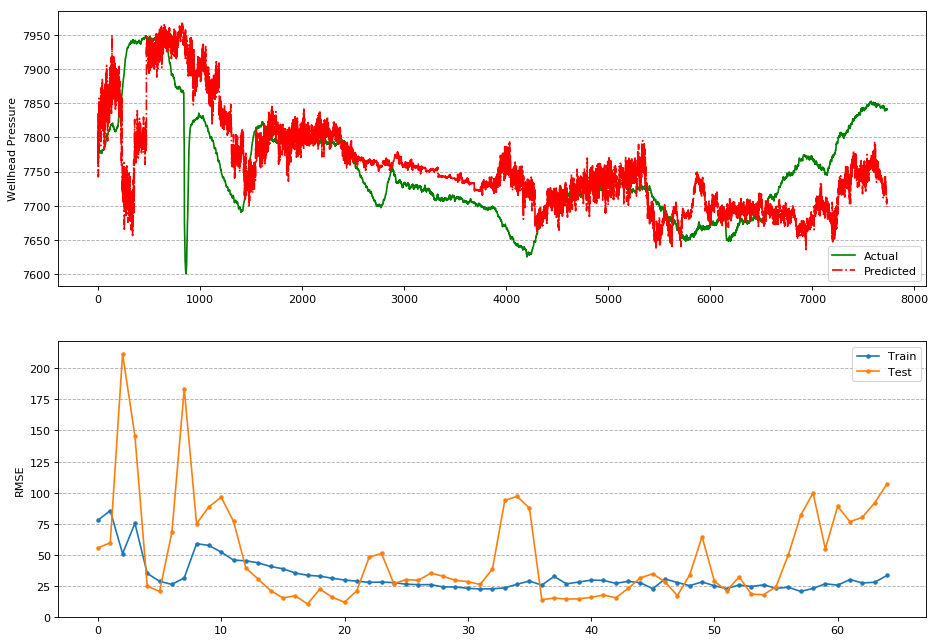

In [16]:
wpp.plot_predictions()